# Выбор локации для скважины

## 0. Вводная часть

### 0.1. Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### 0.2. План выполнения проекта

- Загрузим и подготовим данные.
- Обучим и проверим модель для каждого региона:
 - 2.1. Разбьем данные на обучающую и валидационную выборки в соотношении 75:25.
 - 2.2. Обучим модель и сделаем предсказания на валидационной выборке.
 - 2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
 - 2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
 - 2.5. Проанализируем результаты.
- Подготовимся к расчёту прибыли:
 - 3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
 - 3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 
 - 3.3. Напишем выводы по этапу подготовки расчёта прибыли.
- Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - 4.1. Выберем скважины с максимальными значениями предсказаний. 
 - 4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
 - 4.3. Рассчитаем прибыль для полученного объёма сырья.
- Посчитаем риски и прибыль для каждого региона:
 - 5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - 5.2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 - 5.3. Напишем выводы: предложите регион для разработки скважин и обоснуйте выбор.

### 0.3. Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv.
- /datasets/geo_data_2.csv.
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### 0.4. Условия задачи

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### 0.3. Импорт необходимых библиотек

In [ ]:
!pip install -U phik
!pip install -U scikit-learn

In [17]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Optional, Tuple, Literal

from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import phik
import os
import requests

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
RANDOM_STATE = 42

## 1. Загрузка и подготовка данных

### 1.1. Чтение данных

In [4]:
# Загрузим файлы

base_url = "https://huggingface.co/datasets/onejetpilot/well_loc/resolve/main/"

files = [
    ("geo_data_0.csv", "geo_data_0.csv"),
    ("geo_data_1.csv", "geo_data_1.csv"),
    ("geo_data_2.csv", "geo_data_2.csv")
]

for filename, local_path in files:
    if not os.path.exists(local_path):
        print(f"Файл {filename} не найден — начинаю скачивание...")

        file_url = base_url + filename
        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(local_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Файл успешно скачан: {local_path}")
        else:
            print(f"Ошибка при скачивании {filename}: {response.status_code}")
    else:
        print(f"Файл {filename} уже есть локально — загрузка пропущена")


geo_0 = pd.read_csv("geo_data_0.csv", index_col="id", sep=",")
geo_1 = pd.read_csv("geo_data_1.csv", index_col="id", sep=",")
geo_2 = pd.read_csv("geo_data_2.csv", index_col="id", sep=",")

print("Все файлы успешно загружены в DataFrame")

Файл geo_data_0.csv не найден — начинаю скачивание...
Файл успешно скачан: geo_data_0.csv
Файл geo_data_1.csv не найден — начинаю скачивание...
Файл успешно скачан: geo_data_1.csv
Файл geo_data_2.csv не найден — начинаю скачивание...
Файл успешно скачан: geo_data_2.csv
Все файлы успешно загружены в DataFrame


In [5]:
# Проверим размеры получившихся датасетов
print(geo_0.shape)
print(geo_1.shape)
print(geo_2.shape)

(100000, 4)
(100000, 4)
(100000, 4)


### 1.2. Изучение общей информации о датасетах

In [6]:
def overview_data(
        data: pd.DataFrame
) -> None:
    """
    Выводит информацию о DataFrame - типы данных,
    статистику, количество пропусков и дубликатов

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, для которой требуется провести обзор

    Возвращает
    ----------
    None
        Функция выводит информацию
    """

    d = '-' * 50

    print(d)
    print('Инфо')
    print(d)
    data.info()
    print('\n')

    print(d)
    print('Статистика')
    print(d)
    print(data.describe())
    print('\n')

    print(d)
    print('Пропуски')
    print(d)
    print(data.isna().sum())
    print('\n')

    print(d)
    print('Дубликаты')
    print(d)
    print(data.duplicated().sum())
    print('\n')

    print(d)
    print('Нулевые значения')
    print(d)
    print((data == 0).sum())
    print('\n')

In [7]:
# Выведем общую информацию о датасете geo_0

overview_data(geo_0)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


--------------------------------------------------
Статистика
--------------------------------------------------
             f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       0.50      0.25      2.50     92.50
std        0.87      0.50      3.25     44.29
min       -1.41     -0.85    -12.09      0.00
25%       -0.07     -0.20      0.29     56.50
50%        0.50      0.25      2.52     91.85
75%        1.07      0.70      4.72    128.56
max        2.36      1.34  

In [8]:
# Выведем общую информацию о датасете geo_1

overview_data(geo_1)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


--------------------------------------------------
Статистика
--------------------------------------------------
             f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       1.14     -4.80      2.49     68.83
std        8.97      5.12      1.70     45.94
min      -31.61    -26.36     -0.02      0.00
25%       -6.30     -8.27      1.00     26.95
50%        1.15     -4.81      2.01     57.09
75%        8.62     -1.33      4.00    107.81
max       29.42     18.73  

In [9]:
# Выведем общую информацию о датасете geo_2

overview_data(geo_2)

--------------------------------------------------
Инфо
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


--------------------------------------------------
Статистика
--------------------------------------------------
             f0        f1        f2   product
count 100000.00 100000.00 100000.00 100000.00
mean       0.00     -0.00      2.50     95.00
std        1.73      1.73      3.47     44.75
min       -8.76     -7.08    -11.97      0.00
25%       -1.16     -1.17      0.13     59.45
50%        0.01     -0.01      2.48     94.93
75%        1.16      1.16      4.86    130.60
max        7.24      7.84  

### 1.3. Предобработка данных

In [10]:
# Посмотрим количество уникальных значений в датасете geo_0

geo_0.nunique()

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [11]:
# Посмотрим количество уникальных значений в датасете geo_1

geo_1.nunique()

f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [12]:
# Рассмотрим уникальные значения в столбце product

print(list(geo_1['product'].unique()))

[3.179102583207246, 26.95326103153969, 134.76630515769844, 137.94540774090564, 84.03888567782631, 110.992146709366, 53.90652206307938, 0.0, 107.81304412615876, 57.08562464628662, 30.132363614746943, 80.85978309461906]


In [13]:
geo_1['product'].value_counts()

product
53.91     8472
26.95     8468
84.04     8431
57.09     8390
3.18      8337
80.86     8320
30.13     8306
134.77    8304
110.99    8303
0.00      8235
137.95    8233
107.81    8201
Name: count, dtype: int64

В датасете geo_1 только 12 уникальных значения по product. Возможно пробы были взяты близко друг к другу и показывают одинаковые месторождения, т.к. невероятно чтобы месторождения были абсолютно одинаковы. 

In [14]:
# Посмотрим количество уникальных значений в датасете geo_2

geo_2.nunique()

f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [18]:
def num_diag(
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    ylabel: str,
    hue: Optional[str] = None
) -> None:
    """
    Визуализирует распределение числового признака с помощью гистограммы и boxplot

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных, содержащая признак

    x : str
        Название числового признака, по которому строятся графики.

    xlabel : str
        Подпись оси X для графиков

    ylabel : str
        Подпись оси Y для графиков.=

    hue : str, optional
        Название категориального признака для разделения данных по цветам на гистограмме

    Возвращает
    ----------
    None
        Функция строит графики
    """


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat='density',
        bins=20,
        common_norm=False)
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1])
    axes[1].set_title(f'Гистограмма размаха по {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [19]:
def cat_diag(
    data: pd.DataFrame,
    x: str,
    xlabel: str,
    hue: Optional[str] = None,
    threshold: float = 0.015
) -> None:
    """
    Строит диаграммы распределения для категориального признака:
    countplot с группировкой и круговую диаграмму

    Малые категории по частоте объединяются в категорию "Другие"

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица с данными, содержащая категориальный признак

    x : str
        Название категориального признака, по которому строятся графики

    xlabel : str
        Подпись оси X на countplot

    hue : str, optional
        Название категориального признака для группировки по цветам на countplot

    threshold : float, optional
        Порог частоты (от 0 до 1), ниже которого категории объединяются в "Другие"
        По умолчанию 0.015 (1.5%)

    Возвращает
    ----------
    None
        Функция строит графики
    """


    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts<threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index)
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False)
    axes[1].set_title('Распределение долей')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [20]:
def all_diag(
    data: pd.DataFrame,
    column_type: Literal['numeric', 'categorical', 'date', 'datetime'] = 'numeric',
    hue: Optional[str] = None
) -> None:
    """
    Автоматически визуализирует признаки заданного типа: числовые, категориальные или временные.

    В зависимости от типа признаков вызывает соответствующие функции визуализации
    (num_diag, cat_diag, date_diag) для каждого подходящего столбца в DataFrame.

    Параметры
    ----------
    data : pandas.DataFrame
        Таблица данных для анализа

    column_type : str, optional
        Тип признаков для визуализации. Возможные значения:
        - 'numeric' - числовые признаки
        - 'categorical' - категориальные признаки
        - 'date' или 'datetime' - временные признаки

    hue : str, optional
        Название столбца для цветовой группировки, если нужно

    Возвращает
    ----------
    None
         Функция строит график
    """


    if column_type == 'numeric':
        columns = data.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = data.select_dtypes(include=['object', 'category']).columns
    elif column_type in ('date', 'datetime'):
        columns = data.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns

    for col in columns:
        if column_type == 'numeric':
            print(f'Визуализация числового признака: {col}')
            num_diag(data, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f'Визуализация категориального признака {col}')
            cat_diag(data, x=col, xlabel=col, hue=hue)
        elif column_type == 'date':
            print(f'Визуализация верменного признака: {col}')
            date_diag(data, x=col, hue=hue)

### 1.4. Анализ числовых признаков

Визуализация числового признака: f0


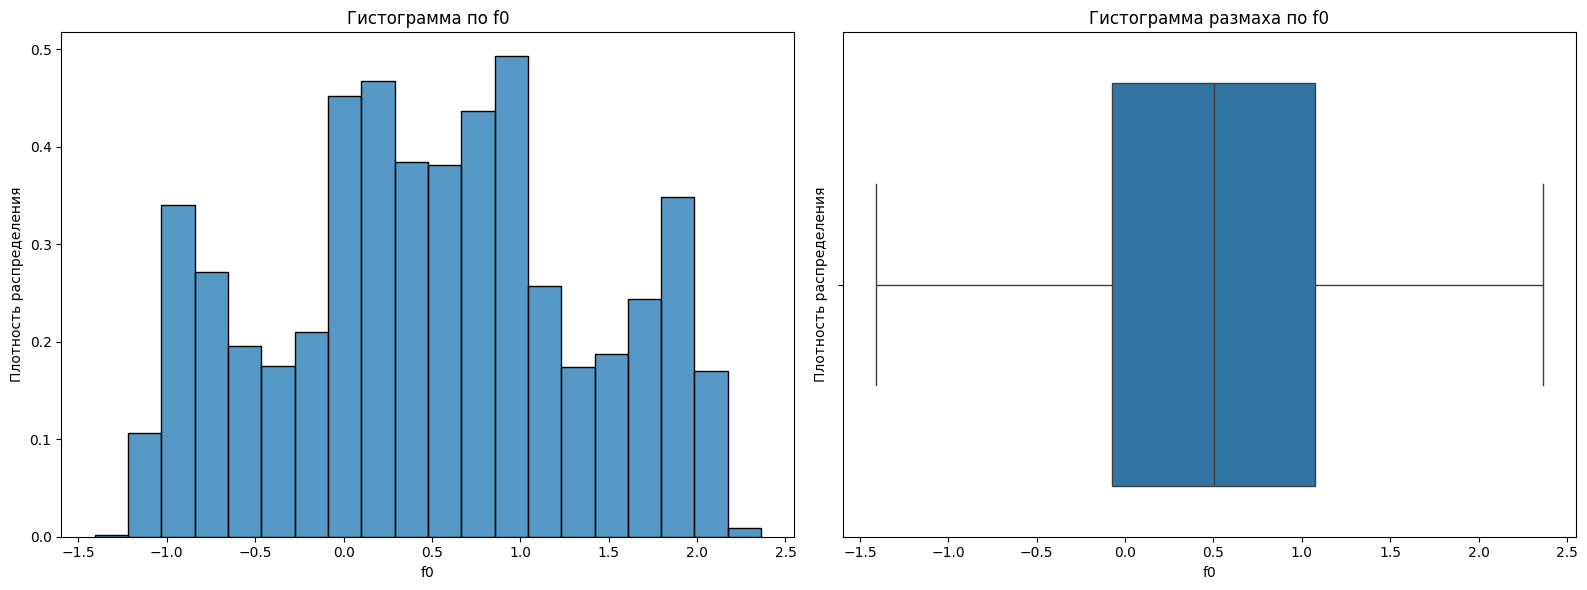

Визуализация числового признака: f1


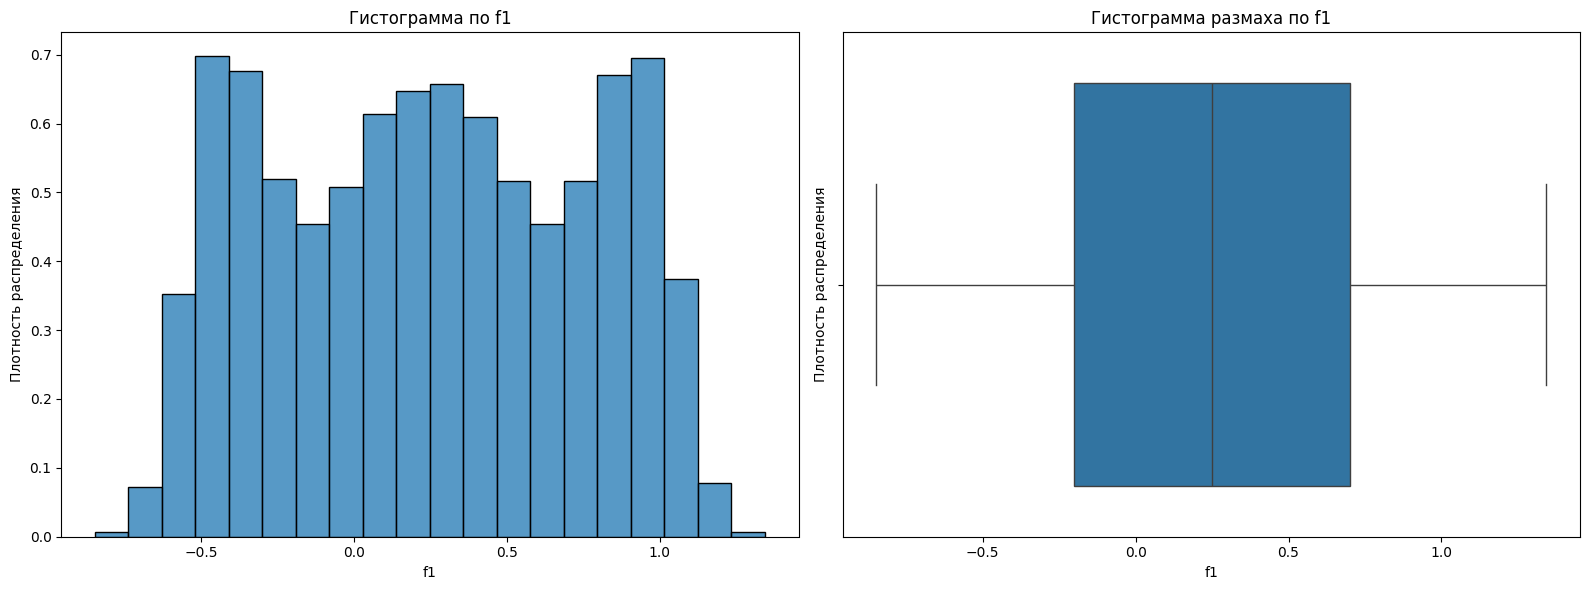

Визуализация числового признака: f2


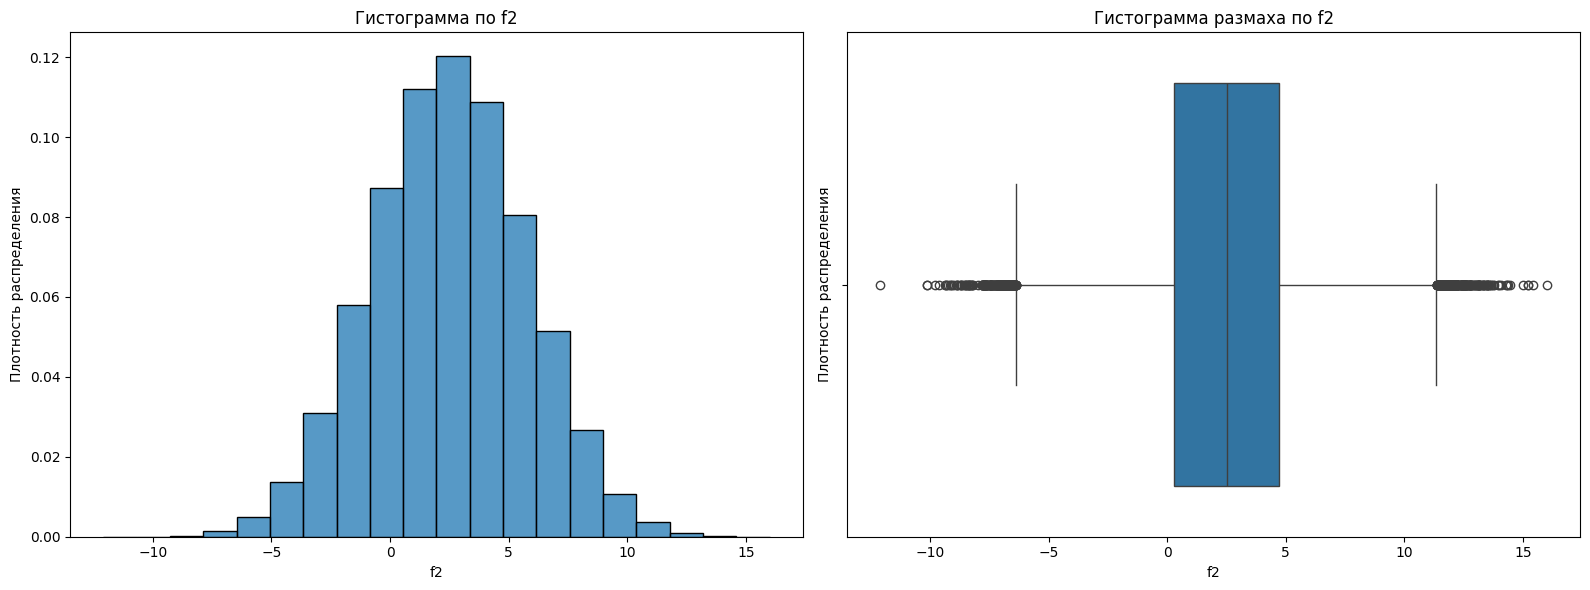

Визуализация числового признака: product


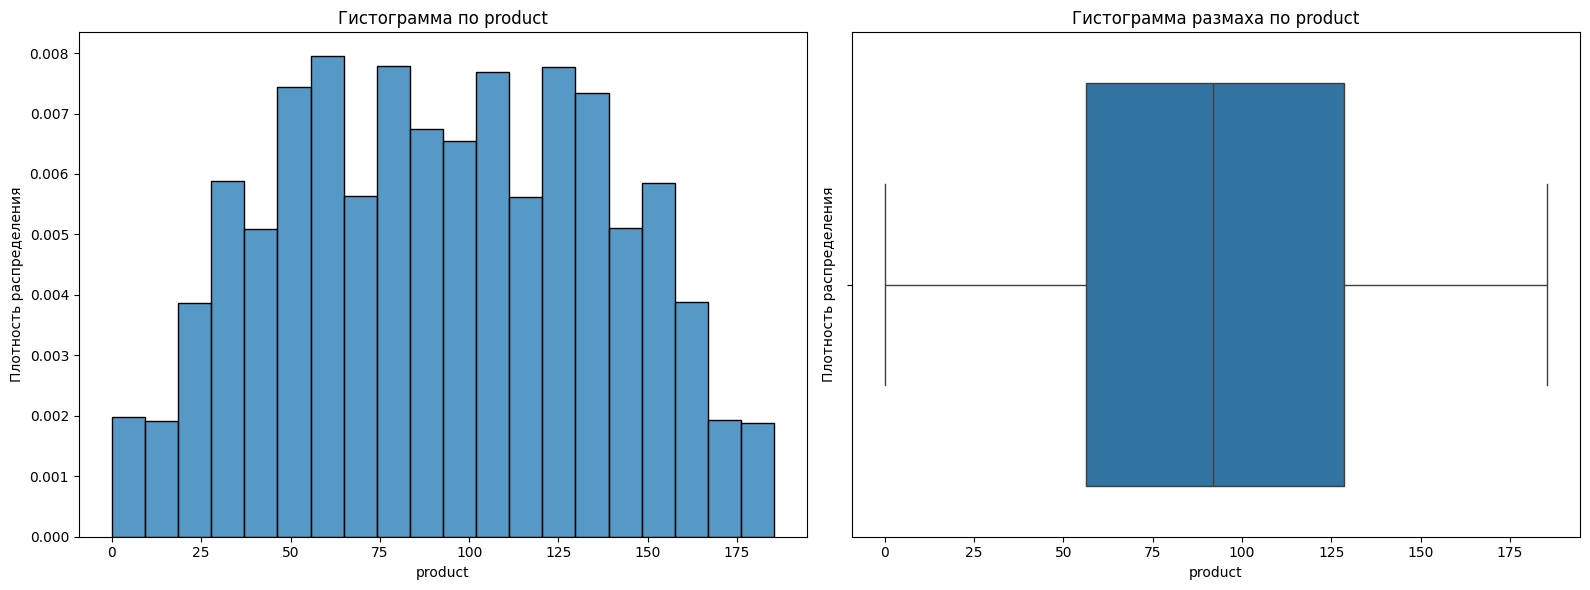

In [21]:
# Визуализируем числовые признаки датасета geo_0
all_diag(geo_0, column_type='numeric', hue=None)

Визуализация числового признака: f0


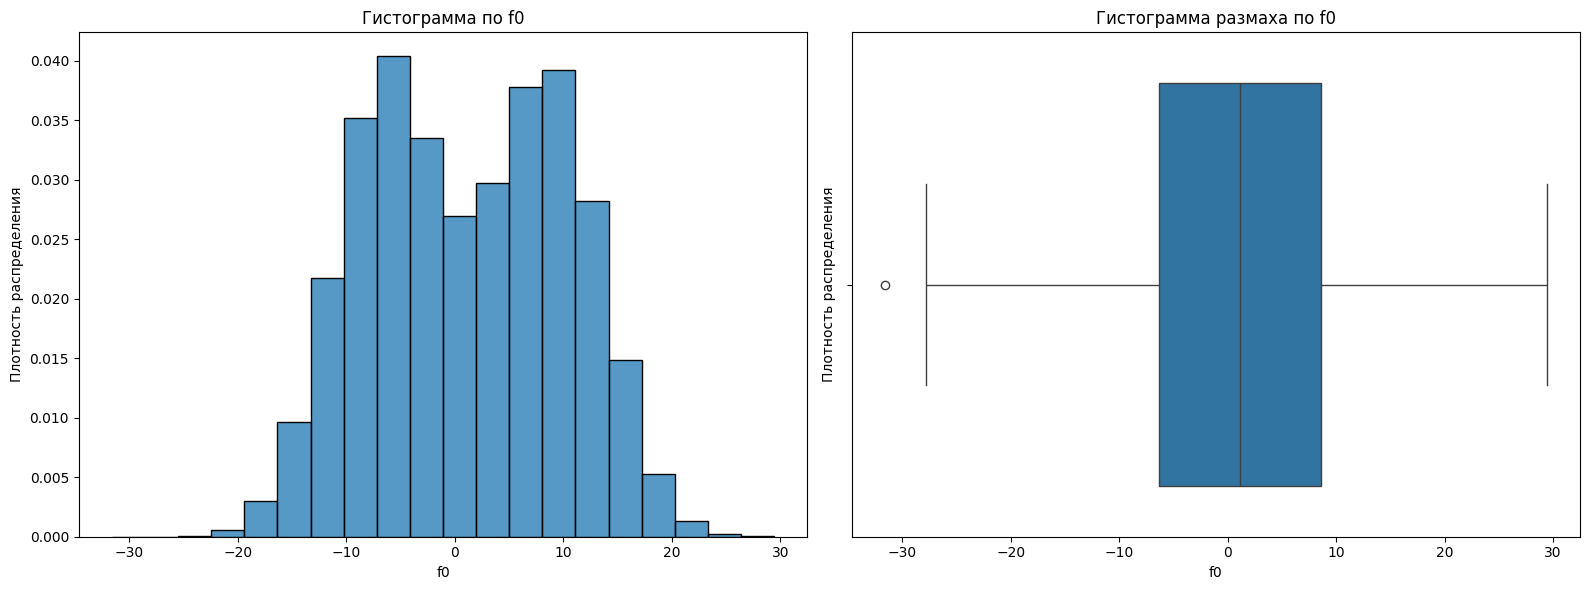

Визуализация числового признака: f1


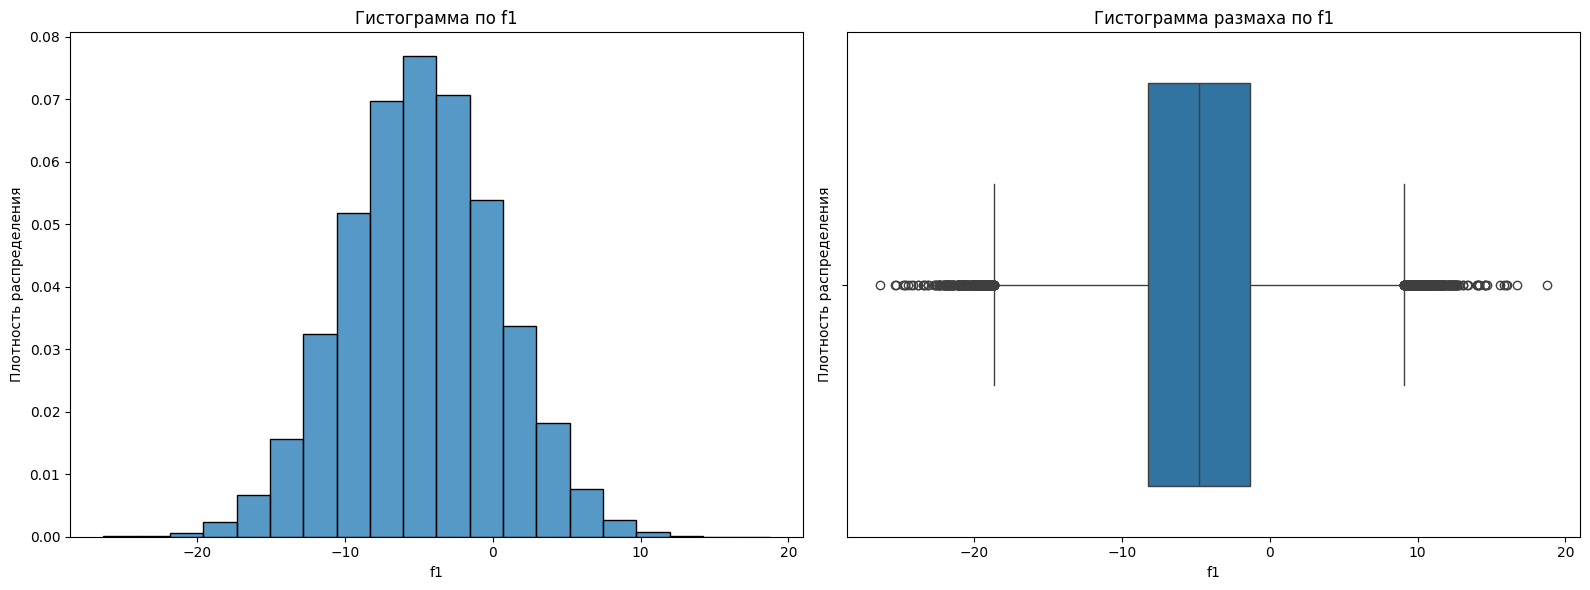

Визуализация числового признака: f2


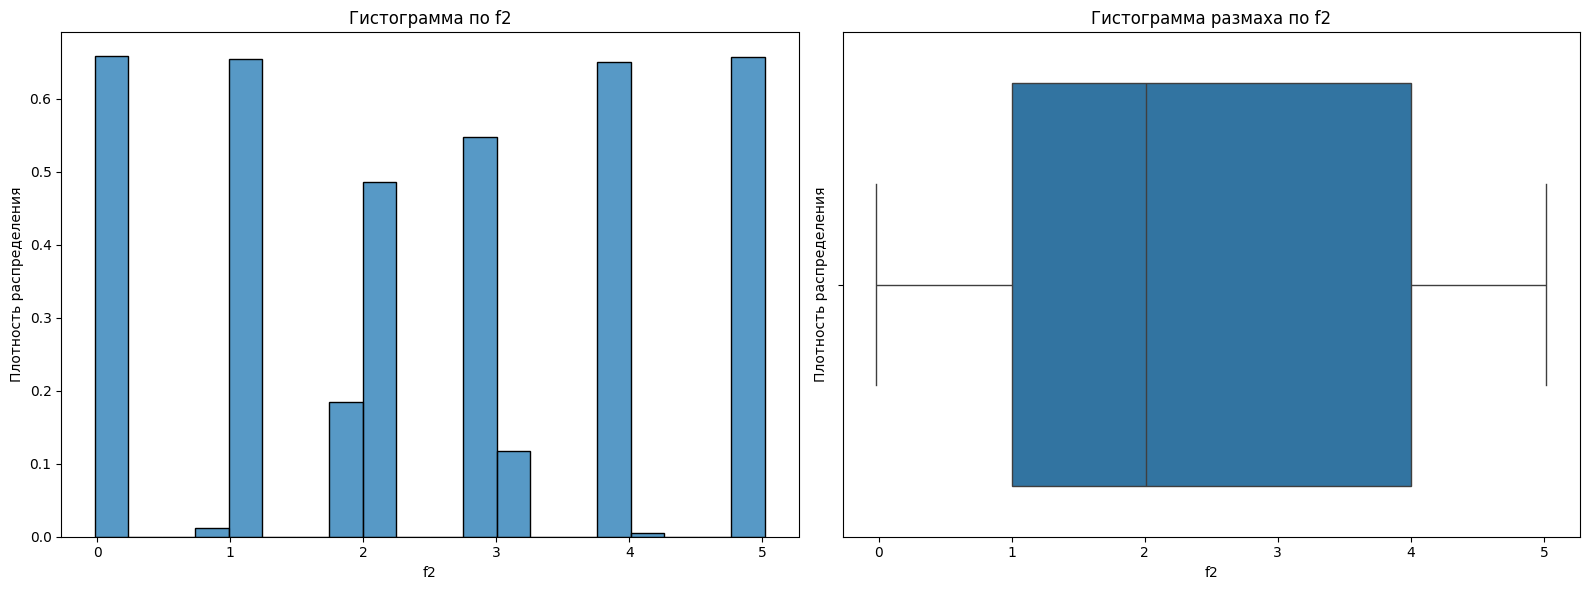

Визуализация числового признака: product


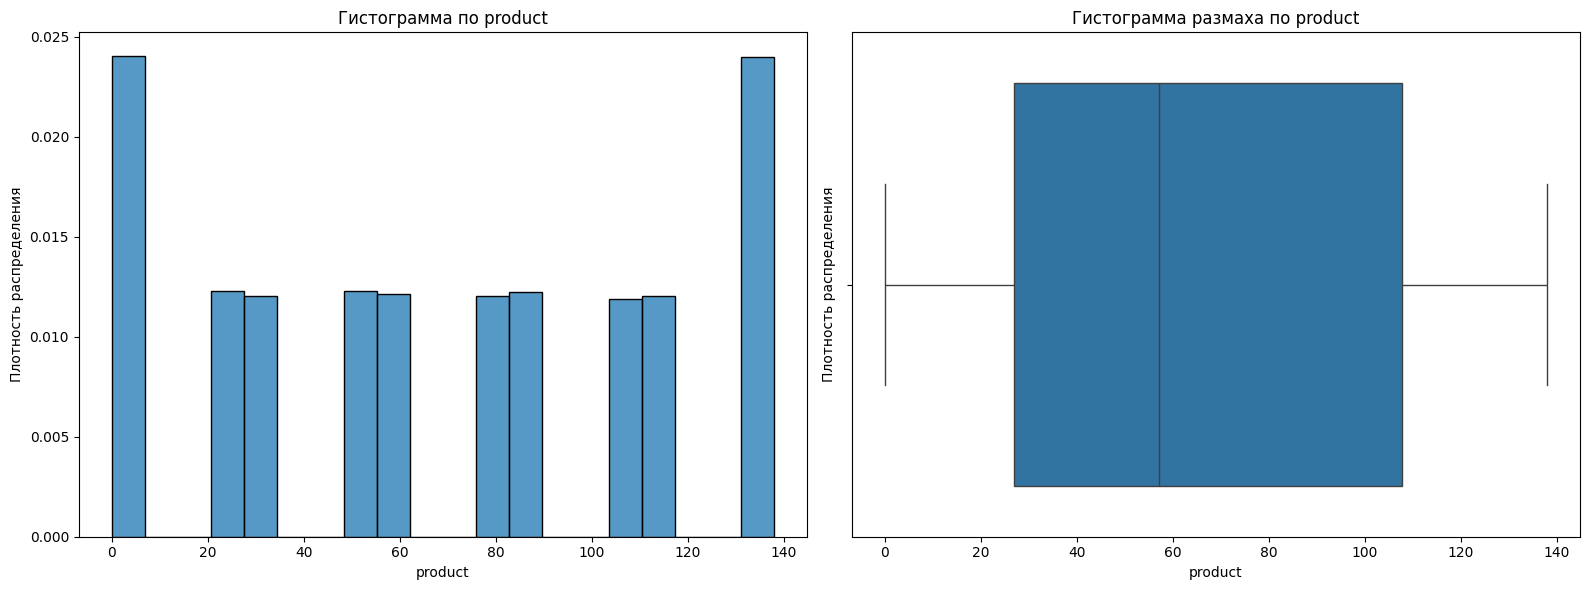

In [22]:
# Визуализируем числовые признаки датасета geo_1
all_diag(geo_1, column_type='numeric', hue=None)

Визуализация числового признака: f0


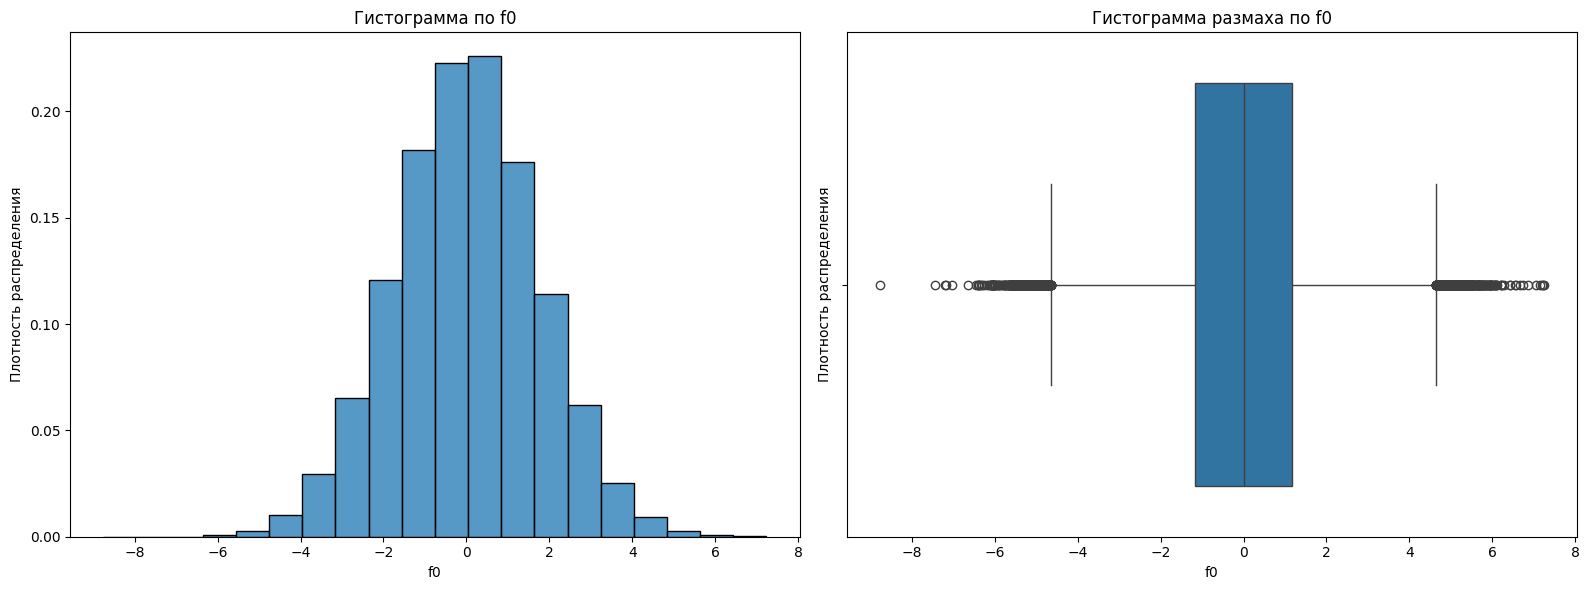

Визуализация числового признака: f1


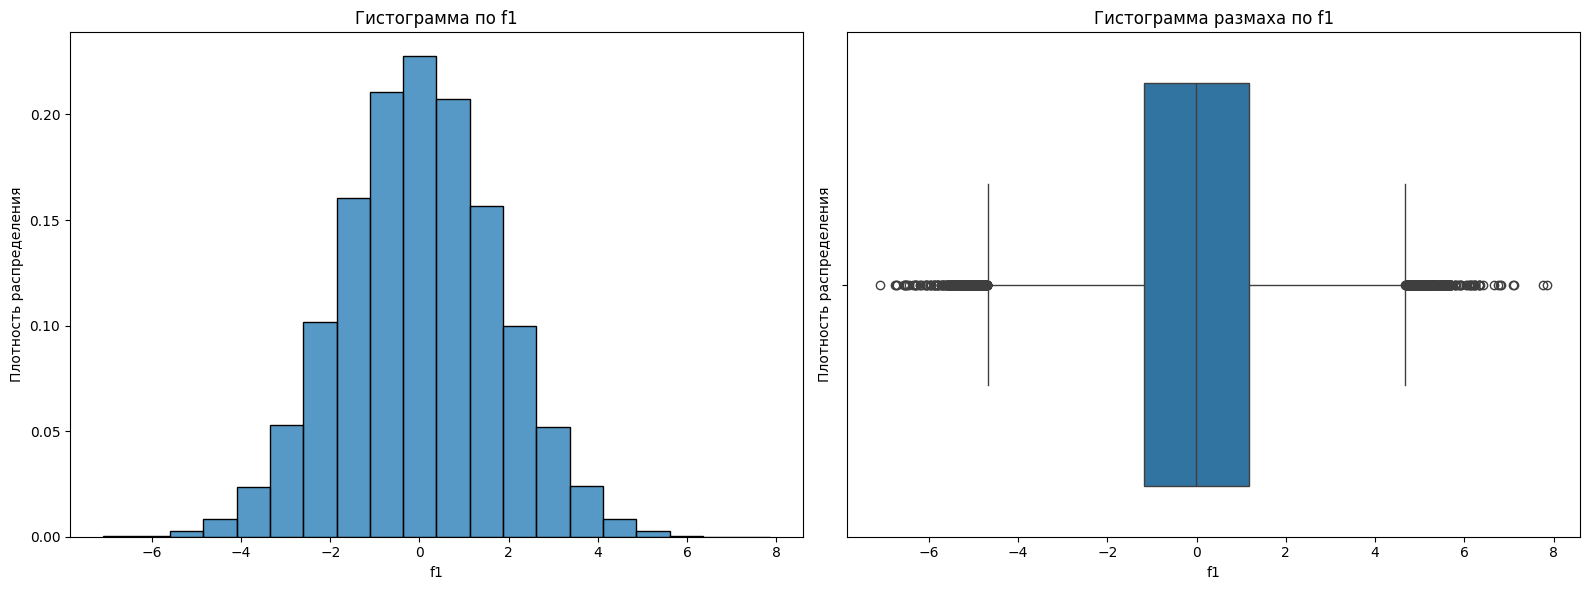

Визуализация числового признака: f2


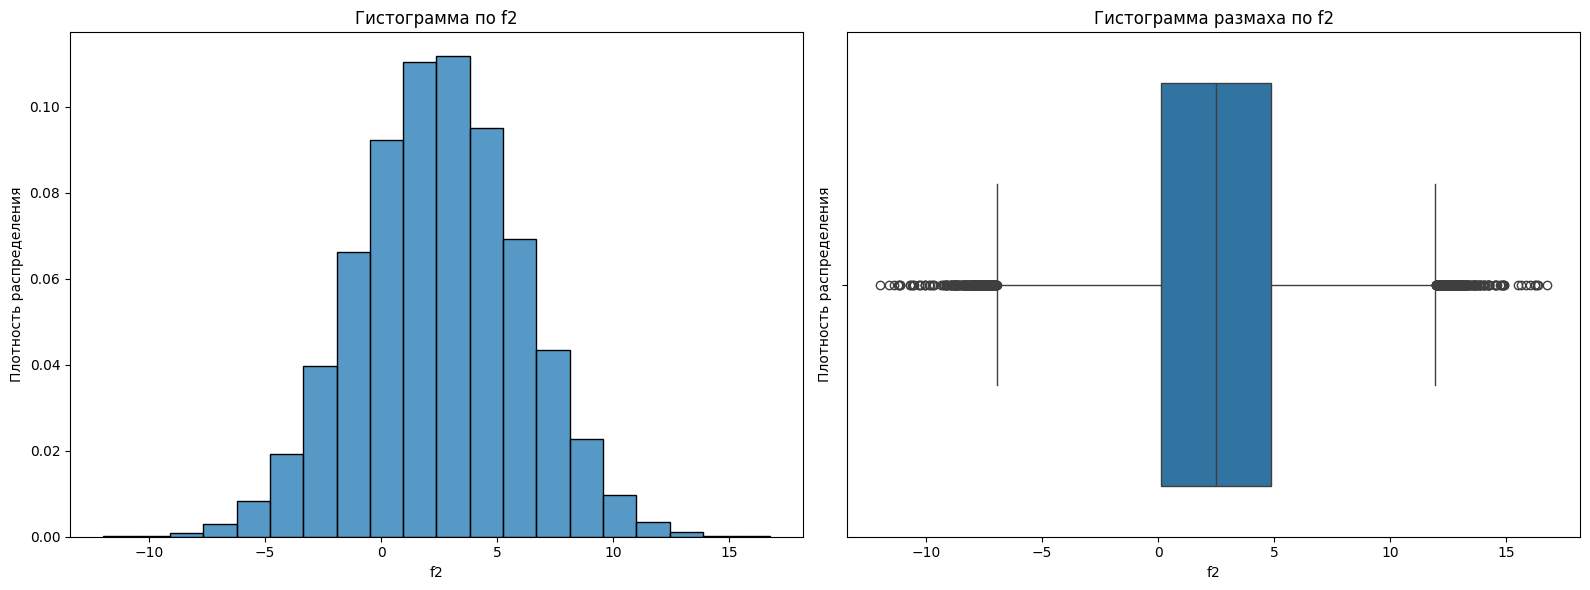

Визуализация числового признака: product


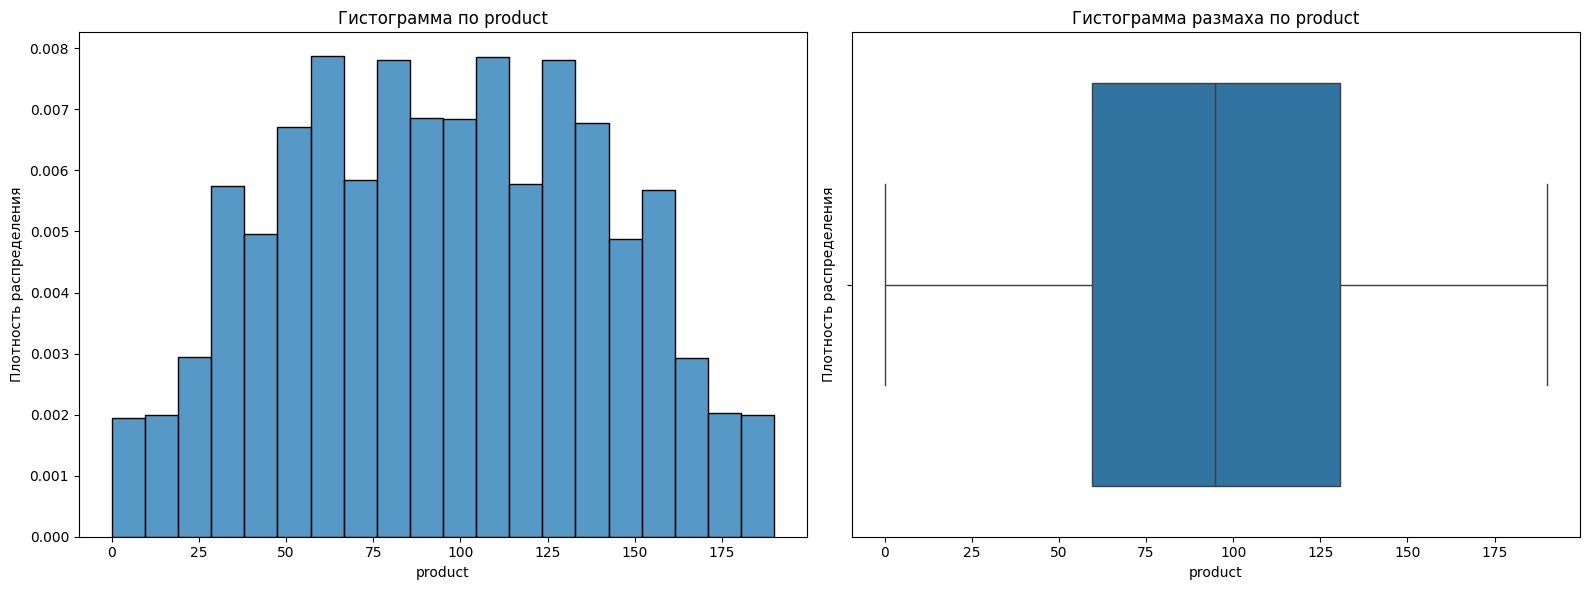

In [23]:
# Визуализируем числовые признаки датасета geo_2
all_diag(geo_2, column_type='numeric', hue=None)

### 1.5. Матрица корреляции

In [24]:
# Построим матрицу корреляции между признаками в датасете geo_0

display(geo_0.corr())

f0    f1    f2  product
f0       1.00 -0.44 -0.00     0.14
f1      -0.44  1.00  0.00    -0.19
f2      -0.00  0.00  1.00     0.48
product  0.14 -0.19  0.48     1.00

In [25]:
# Cоздадим матрицу корреляции phik

phk_m_0 = geo_0.phik_matrix(verbose=False)

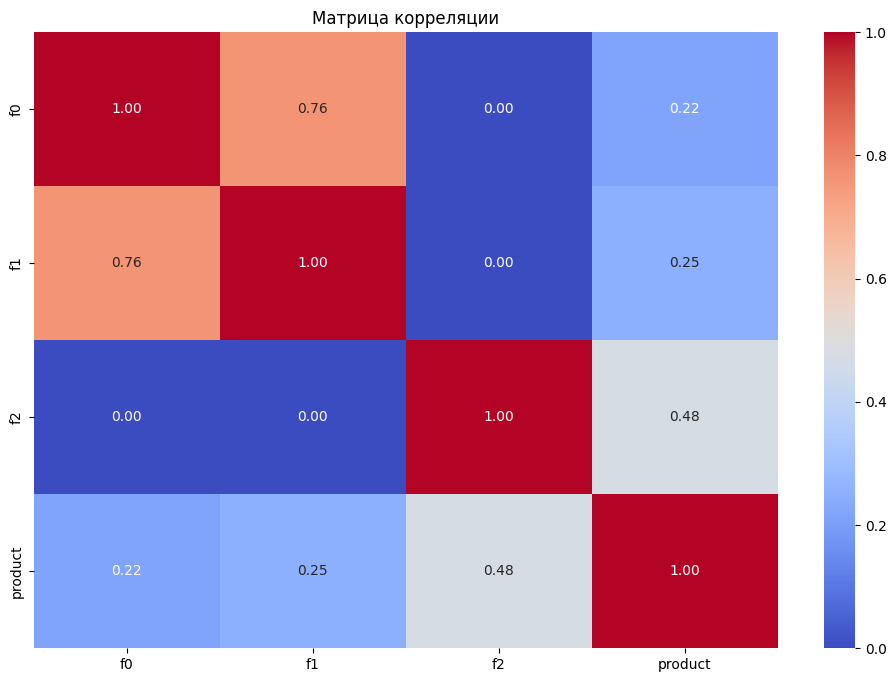

In [26]:
# Визуализируем матрицу корреляции 

plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции')
sns.heatmap(phk_m_0, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

В датасете geo_0 признаки имеют умеренную корреляцию с целевым.

In [27]:
# Построим матрицу корреляции между признаками в датасете geo_1

display(geo_1.corr())

f0    f1    f2  product
f0       1.00  0.18 -0.00    -0.03
f1       0.18  1.00 -0.00    -0.01
f2      -0.00 -0.00  1.00     1.00
product -0.03 -0.01  1.00     1.00

In [28]:
# Cоздадим матрицу корреляции phik

phk_m_1 = geo_1.phik_matrix(verbose=False)

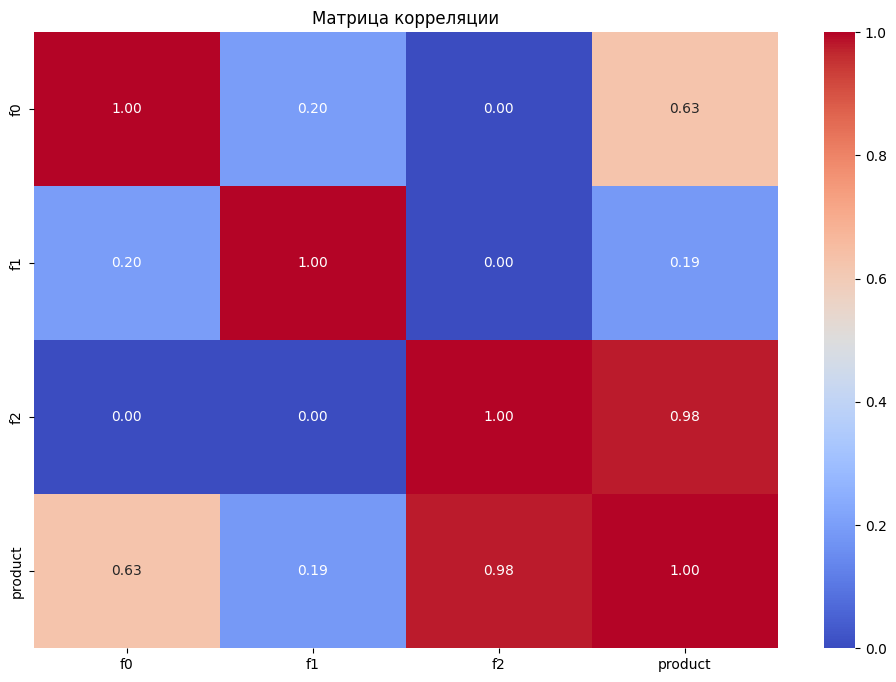

In [29]:
# Визуализируем матрицу корреляции 

plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции')
sns.heatmap(phk_m_1, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

В датасете geo_1 признак f2 имеет сильную корреляцию с целевой переменной, почти 1 - т.е. почти полностью повторяет целевую переменную. 

In [30]:
# Построим матрицу корреляции между признаками в датасете geo_0

display(geo_2.corr())

f0    f1    f2  product
f0       1.00  0.00 -0.00    -0.00
f1       0.00  1.00  0.00    -0.00
f2      -0.00  0.00  1.00     0.45
product -0.00 -0.00  0.45     1.00

In [31]:
# Cоздадим матрицу корреляции phik

phk_m_2 = geo_2.phik_matrix(verbose=False)

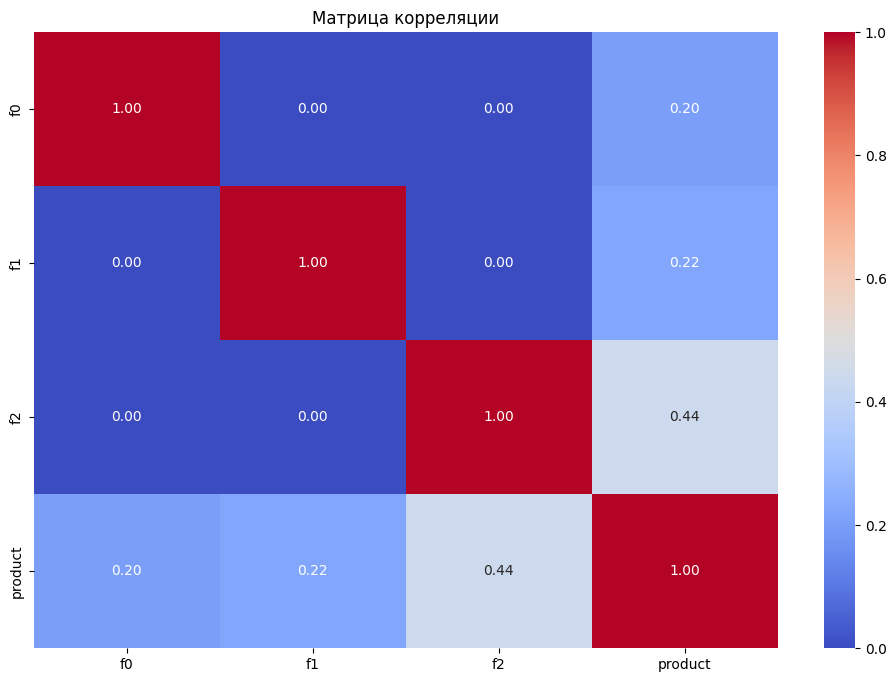

In [32]:
# Визуализируем матрицу корреляции 

plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции')
sns.heatmap(phk_m_2, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

В geo_2 признаки имеют умеренную или низкую корреляцию с целевым.

### 1.6. Мультиколлениарность

In [33]:
# Добавим константу

df_with_const_0 = add_constant(geo_0)
df_with_const_1 = add_constant(geo_1)
df_with_const_2 = add_constant(geo_2)

In [34]:
# Выберем только числовые колонки и удалим таргет

num_columns = df_with_const_0.select_dtypes(include='number').columns.drop('product')

In [35]:
# Определим функцию подсчета VIF

def calc_vif(df):

    vif_data = pd.DataFrame()
    vif_data["variables"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [36]:
# Рассчитаем VIF для региона geo_0

calc_vif(df_with_const_0[num_columns])

variables  VIF
0     const 2.62
1        f0 1.24
2        f1 1.24
3        f2 1.00

In [37]:
# Рассчитаем VIF для региона geo_1

calc_vif(df_with_const_1[num_columns])

variables  VIF
0     const 4.11
1        f0 1.03
2        f1 1.03
3        f2 1.00

In [38]:
# Рассчитаем VIF для региона geo_2

calc_vif(df_with_const_2[num_columns])

variables  VIF
0     const 1.52
1        f0 1.00
2        f1 1.00
3        f2 1.00

Ключевые пороги для VIF:
- VIF < 5: Минимальная мультиколлинеарность, это нормально.
- 5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.
- VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.

Все признаки < 5 - мультиколлениарности в датасетах нет.

### 1.7 Зависимости признаков от целевого

In [39]:
def scatt_diag(
    data: pd.DataFrame,
    x: str,
    y: str,
    xlabel: str,
    ylabel: str
) -> None:
    """
    Строит простую диаграмму рассеяния (scatter plot) для двух числовых признаков.

    Параметры
    ---------
    data : pd.DataFrame
        Датасет, содержащий числовые признаки, указанные в аргументах x и y.

    x : str
        Название столбца, который будет использован по оси X.

    y : str
        Название столбца, который будет использован по оси Y.

    xlabel : str
        Подпись оси X.

    ylabel : str
        Подпись оси Y.

    Возвращает
    ----------
    None
        Функция ничего не возвращает — она строит график и отображает его.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        s=100,
        ax=ax
    )

    ax.set_title('Диаграмма рассеяния')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

Построим диаграммы рассеяния по признакам датасета geo_0

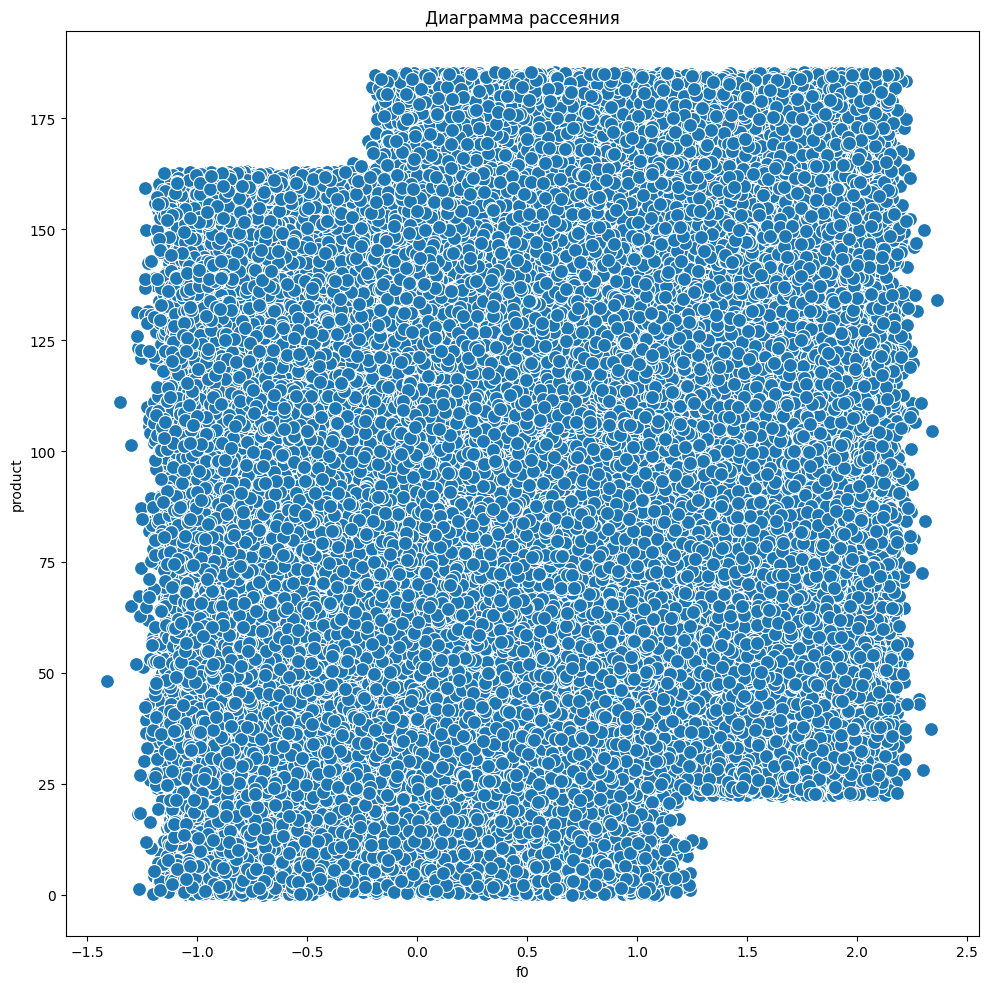

In [40]:
# Построим диаграмму рассеяния f0 и pruduct

scatt_diag(geo_0, 'f0', 'product', 'f0', 'product')

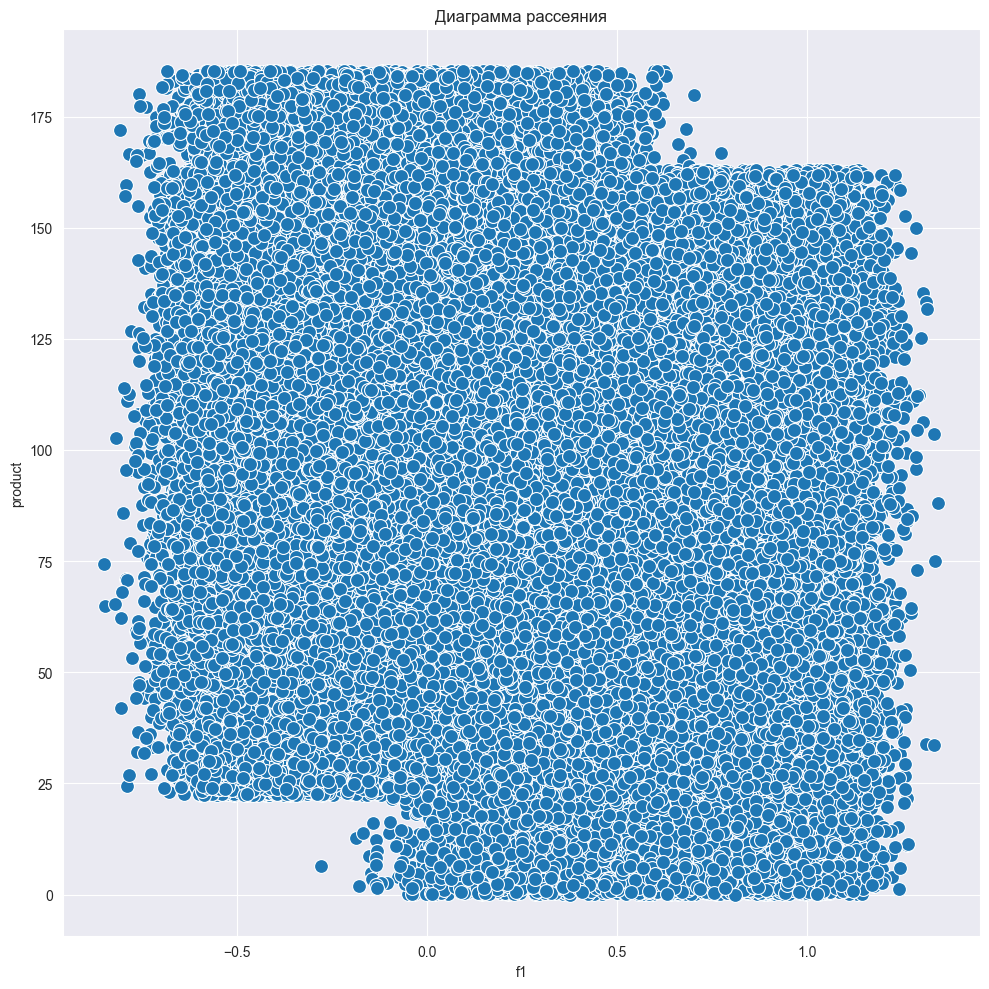

In [98]:
# Построим диаграмму рассеяния f1 и pruduct
scatt_diag(geo_0, 'f1', 'product', 'f1', 'product')

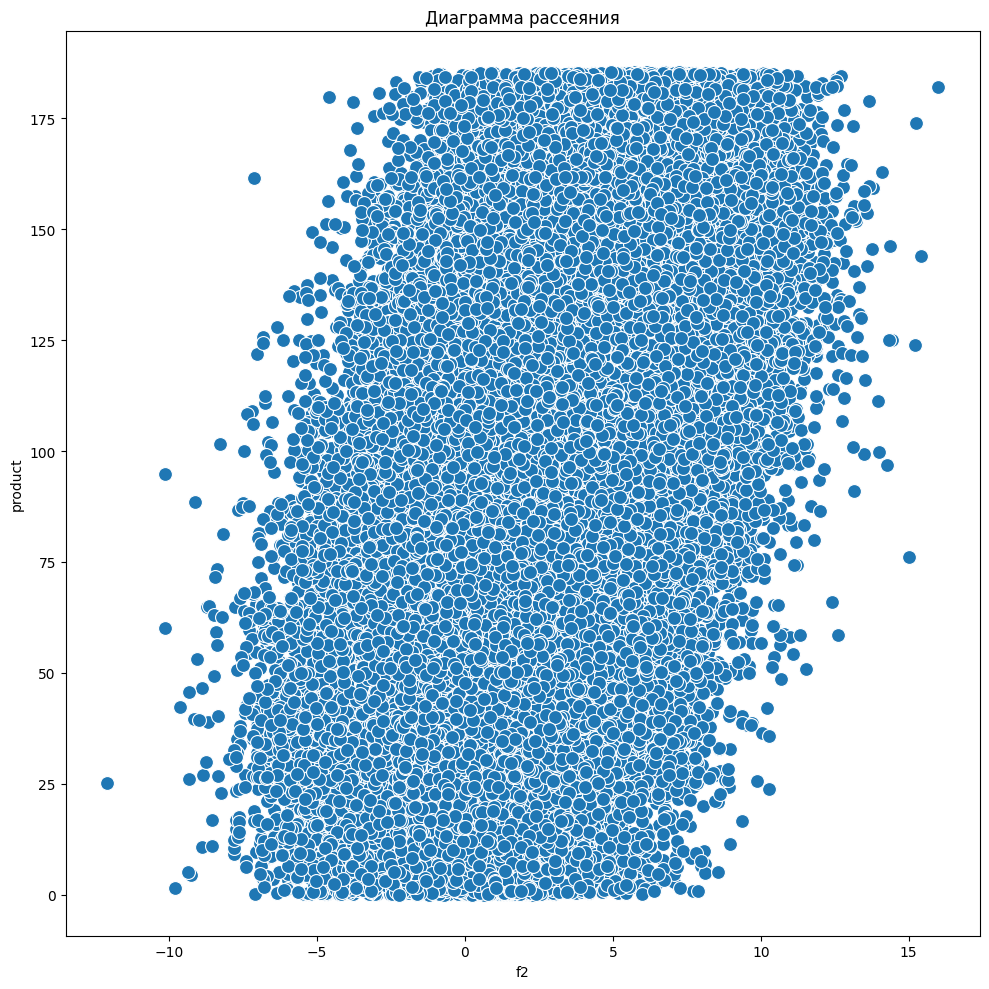

In [41]:
# Построим диаграмму рассеяния f2 и pruduct

scatt_diag(geo_0, 'f2', 'product', 'f2', 'product')

Выводы по графикам: По графикам взаимосвязи f0 и f1 с целевым признаком product сложно сказать что либо. Данные на графике f0 и product похоже сосредоточены около прямой.

Построим диаграммы рассеяния по признакам датасета geo_1

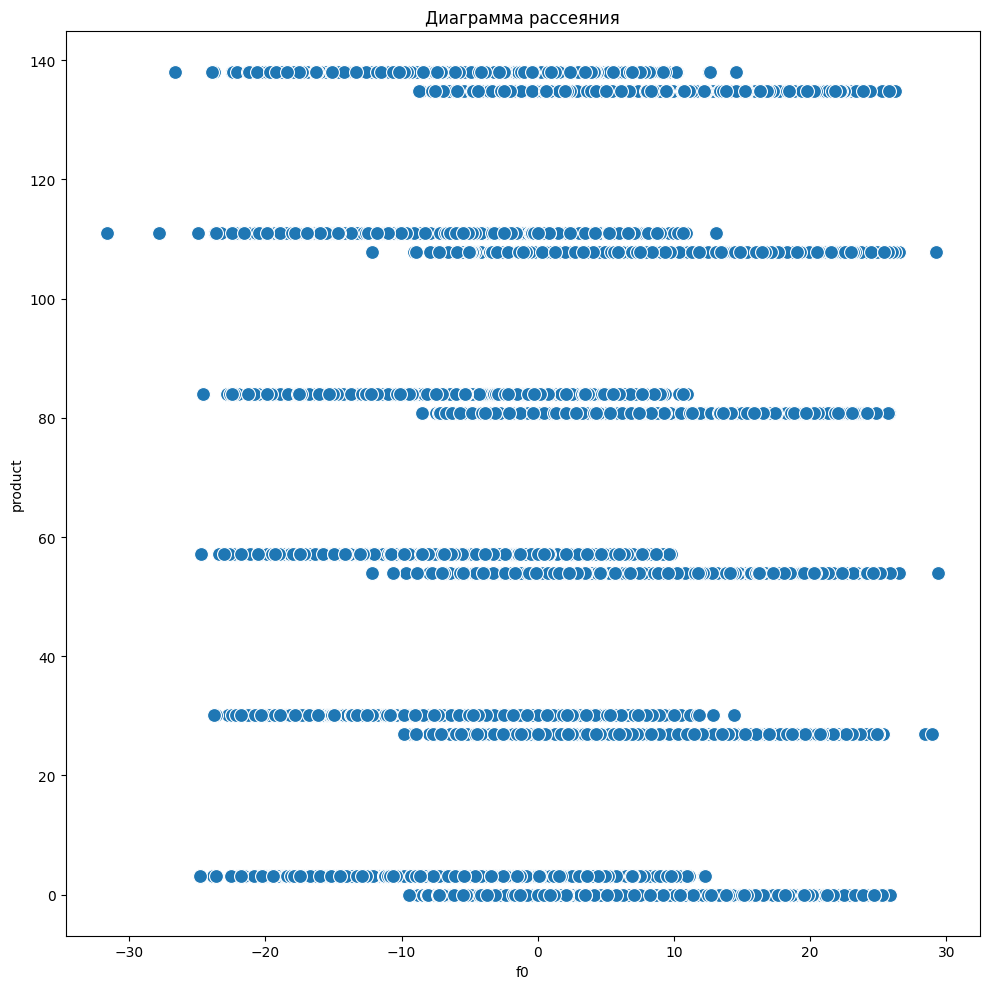

In [42]:
# Построим диаграмму рассеяния f0 и pruduct

scatt_diag(geo_1, 'f0', 'product', 'f0', 'product')

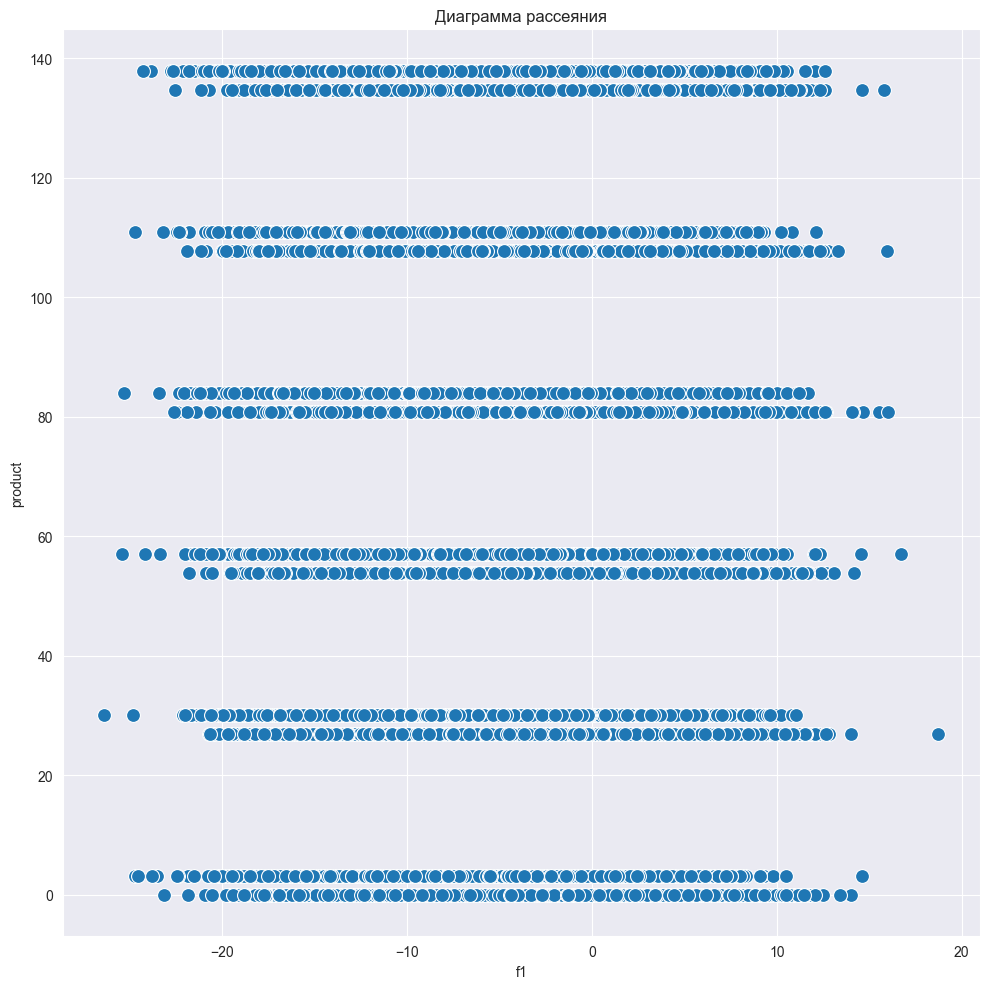

In [101]:
# Построим диаграмму рассеяния f1 и pruduct
scatt_diag(geo_1, 'f1', 'product', 'f1', 'product')

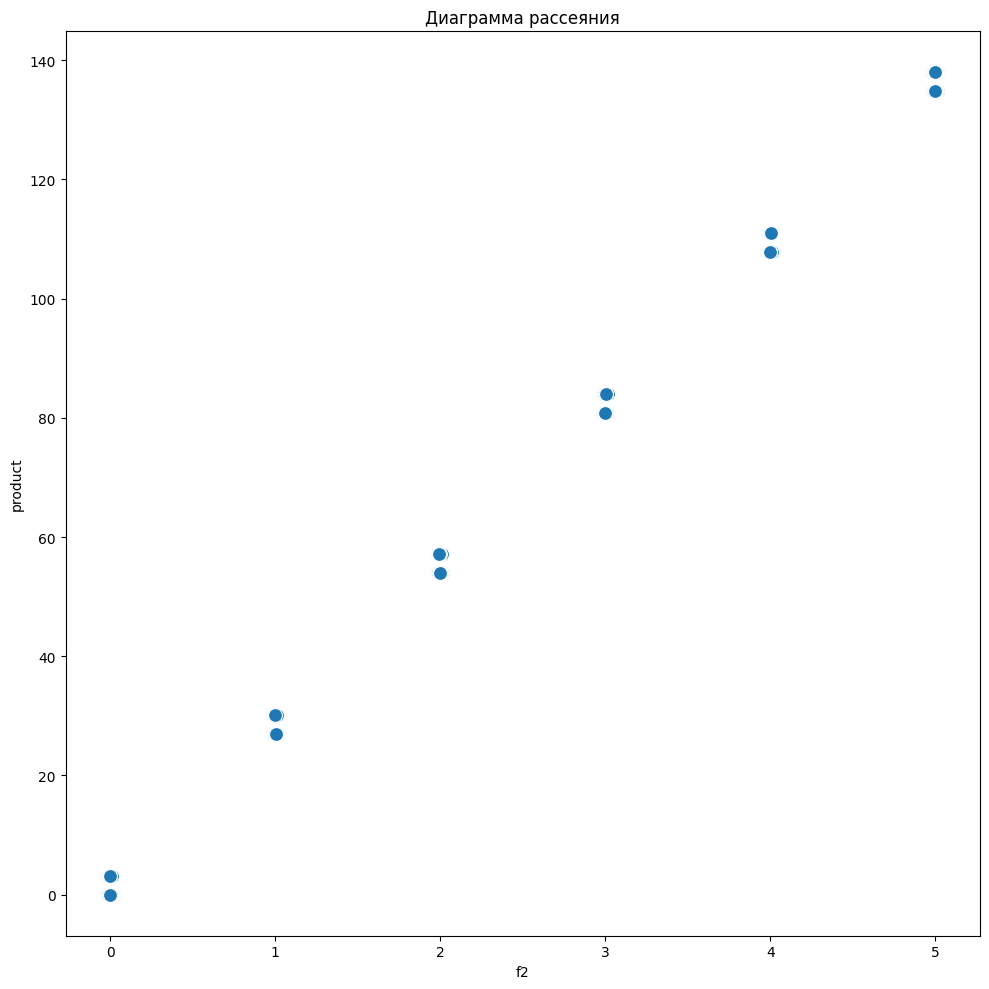

In [43]:
# Построим диаграмму рассеяния f2 и pruduct

scatt_diag(geo_1, 'f2', 'product', 'f2', 'product')

Выводы по графикам: По графикам взаимосвязи f0 и f1 сложно сделать какие либо выводы, f0 и product имеет корреляцию почти 1, что мы и видим на графике. 

Построим диаграммы рассеяния по признакам датасета geo_2

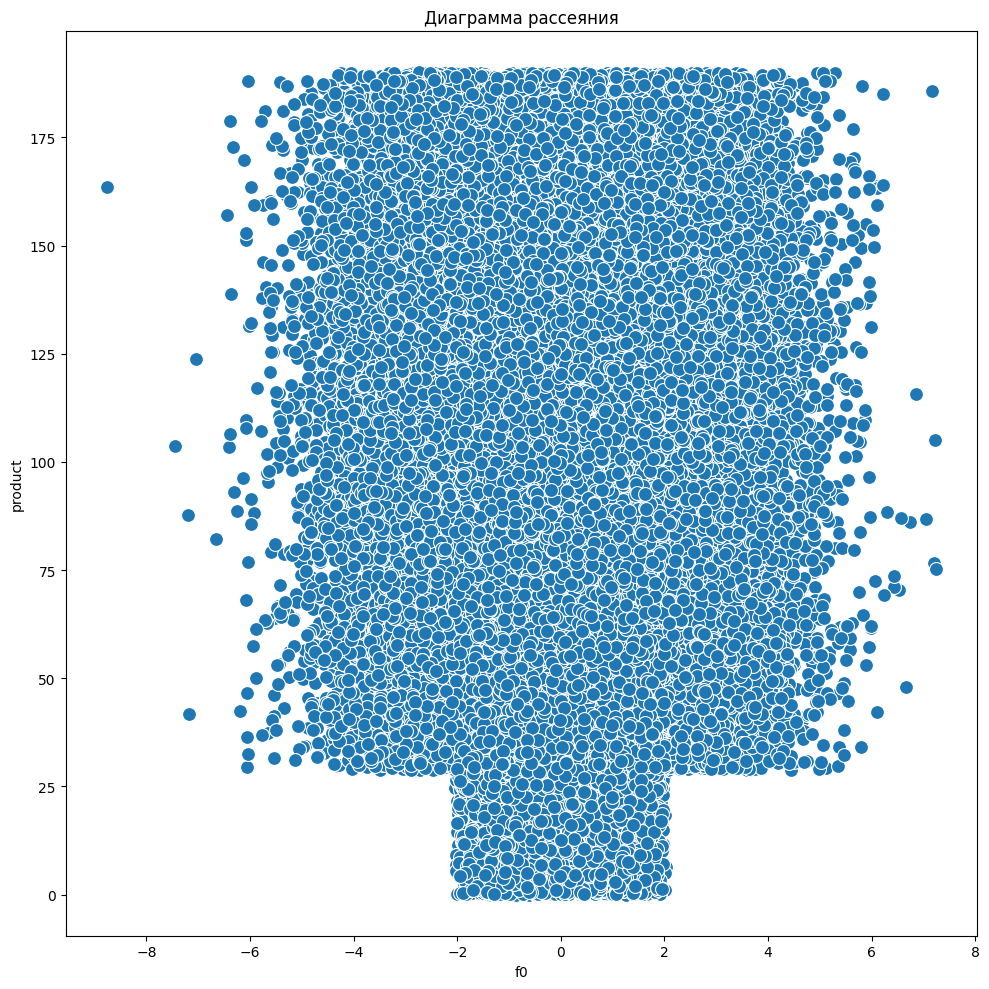

In [44]:
# Построим диаграмму рассеяния job_satisfaction_rate и employment_years

scatt_diag(geo_2, 'f0', 'product', 'f0', 'product')

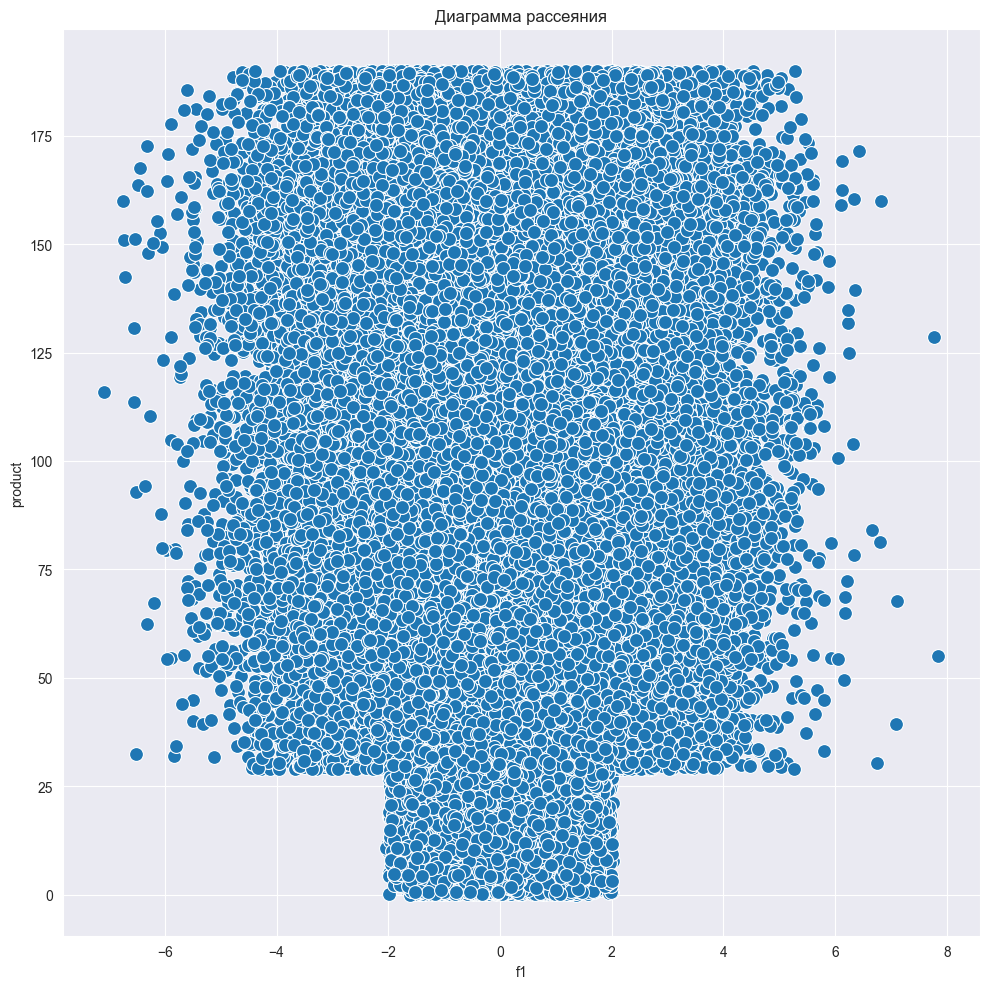

In [104]:
# Построим диаграмму рассеяния job_satisfaction_rate и employment_years
scatt_diag(geo_2, 'f1', 'product', 'f1', 'product')

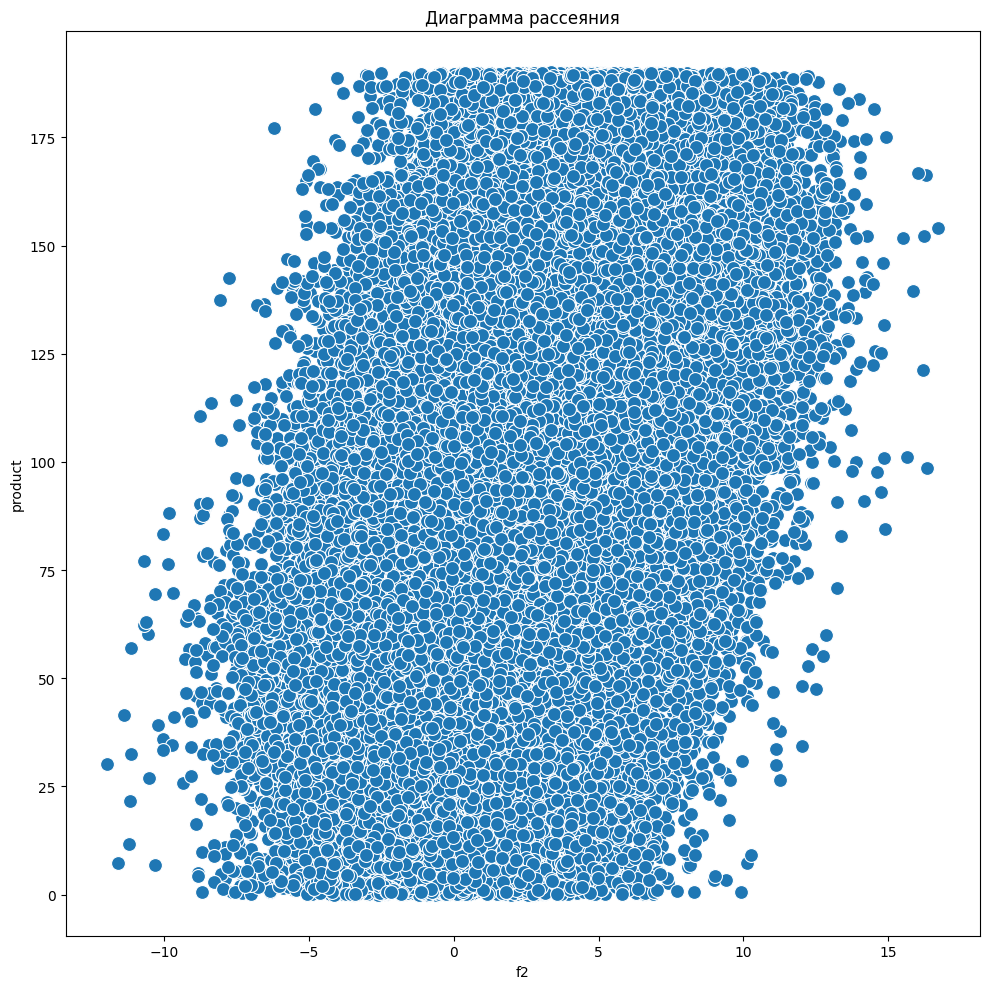

In [45]:
# Построим диаграмму рассеяния job_satisfaction_rate и employment_years

scatt_diag(geo_2, 'f2', 'product', 'f2', 'product')

Выводы по графикам: По графикам взаимосвязи f0 и f1 с целевым признаком product сложно сказать что либо. Данные на графике f0 и product похоже сосредоточены около прямой.

### Вывод

Проведенная работа:
 - Открыли файлы с данными и сохранили их в отдельные переменные
 - Проверили типы данных, дубликаты и пропущенные значения в датасетах
 - Провели исследовательский анализ данных
 - Построили матрицу корреляции
 - Проверили данные на мультиколлениарность
 - Посмотрели зависимости между признаками
 
Результаты анализа:

Явных дубликатов и пропусков не найдено. Явных аномальных значений также не найдено. Типы данных также в порядке.
Возможно в датасете geo_1 пробы были взяты рядом друг с другом.

Выводы по графикам:
 - f0, f1, f2 - 3 признака точек, больше никакой информации по ним нет. Графики имеют разное количество пиков, как и на что это может влиять понимания нет. 
 - product - объем запасов в скважине. Можно сказать, что во всех регионах на рафиках мы видим по 6 пиков.
 В регионе geo_1 эти пики четко разделены, в регионах geo_0 и geo_1 менее выражены. Думаю пики по объемам запасов означают большие месторождения.

Корреляции:
- В датасете geo_1 признак f2 имеет сильную корреляцию с целевой переменной, почти 1 - т.е. почти полностью повторяет целевую переменную. В датасетах geo_0 и geo_2 данные имеют умеренную корреляцию с целевым признаком.

- Мультиколлениарности между признаками в датасетах не найдено. Все признаки по VIF < 5.

- В датасете geo_1 по графикам взаимосвязи f0 и f1 сложно сделать какие либо выводы, f0 и product имеет корреляцию почти 1, что мы и видим на графике. В остальных датасетах каких-то явных зависимостей по графикам определить не удалось.

## 2. Обучение и проверка модели

Обучите и проверьте модель для каждого региона. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

### 2.1. Разбиение данных

In [47]:
def lin_reg(df: pd.DataFrame) -> Tuple[pd.DataFrame, float, float, float]:
    """
    Разбивает данные на обучающую и валидационную выборки (75/25),
    обучает линейную регрессию и рассчитывает метрики.

    Параметры
    ---------
    df : pd.DataFrame
        Датафрейм, содержащий числовые признаки и целевую переменную 'product'.

    Возвращает
    ----------
    Tuple[pd.DataFrame, float, float, float]
        results : pd.DataFrame
            Таблица с реальными значениями цели и предсказаниями модели.
        res_pred_mean : float
            Среднее значение предсказаний модели.
        res_true_mean : float
            Среднее значение реальных значений целевой переменной.
        rmse : float
            Корень из среднеквадратичной ошибки на валидационной выборке.
    """

    X = df.drop('product', axis=1)
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size=0.75, random_state=RANDOM_STATE
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    preds = model.predict(X_val)

    results = pd.DataFrame({
        'product': y_val,
        'product_pred': preds
    })

    rmse = root_mean_squared_error(y_val, preds)

    res_pred_mean = results['product_pred'].mean()
    res_true_mean = results['product'].mean()

    return results, res_pred_mean, res_true_mean, rmse

### 2.2. Обучение модели и предсказания на валидационной выборке

### 2.3. Сохраниние предсказаний и правильных ответов на валидационной выборке

In [48]:
# Обучим модели на всех датасетах

results_0, res_pred_mean_0, res_true_mean_0, rmse_0 = lin_reg(geo_0)
results_1, res_pred_mean_1, res_true_mean_1, rmse_1 = lin_reg(geo_1)
results_2, res_pred_mean_2, res_true_mean_2, rmse_2 = lin_reg(geo_2)

In [49]:
# Создадим датасет с метриками моделей

metrics_geo = pd.DataFrame({
    'model_id': ['geo_0', 'geo_1', 'geo_2'],
    'res_mean': [res_pred_mean_0, res_pred_mean_1, res_pred_mean_2],
    'res_true': [res_true_mean_0, res_true_mean_1, res_true_mean_2],
    'rmse': [rmse_0, rmse_1, rmse_2]
})

### 2.4. Средний запас предсказанного сырья и RMSE модели

In [50]:
# Выведем метрики моделей и средние по запасам в регионах

metrics_geo

model_id  res_mean  res_true  rmse
0    geo_0     92.40     92.33 37.76
1    geo_1     68.71     68.73  0.89
2    geo_2     94.77     95.15 40.15

### Вывод

Проведенная работа:
- Разбили данные на тренировочную и валидационную выборки
- Обучили модель и сделали предсказания на валидационной выборке, сохранили предсказания модели и истинные значения в отдельный датафрейм
- Сохранили средний запас предсказанного сырья и RMSE модели в отдельный датафрейм

Результаты анализа, проблемы и решения:
 
- Лучший показатель RMSE показала модель на данных по региону geo_1. Это ожидаемый результат т.к. один из признаков имеет корреляцию с целевым почти 1. Модель переобучилась.
- Очень высокое значение RMSE в моделях обученных на значениях geo_0 и geo_2, указывает на большие ошибки в предсказаниях. Модели обучились плохо.
- Наиболее богатые регионы по запасам сырья - geo_0 и geo_2

## 3. Подготовка к расчёту прибыли

### 3.1. Все ключевые значения для расчётов

In [51]:
# Сохраним ключевые значения в отдельных переменных

POINTS = 500
BEST_POINTS = 200
BUDGET = 10_000_000_000
UNIT_PROFIT = 450_000

### 3.2. Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объём сырья со средним запасом в каждом регионе

In [52]:
# Рассчитаем достаточный объем сырья для разработки 200 точек

required_volume = BUDGET / (UNIT_PROFIT * BEST_POINTS)
print(f'Достаточный для разработки объем сырья: {required_volume:.2f} тыс. баррелей')

Достаточный для разработки объем сырья: 111.11 тыс. баррелей


In [53]:
# Добавим столбец res_req в датасет с метриками

metrics_geo['res_req'] = required_volume

In [54]:
# Выведем полученный датасет

metrics_geo

model_id  res_mean  res_true  rmse  res_req
0    geo_0     92.40     92.33 37.76   111.11
1    geo_1     68.71     68.73  0.89   111.11
2    geo_2     94.77     95.15 40.15   111.11

### Вывод

Проведенная работа:
- Сохранили значения данные условием задачи в отдельных переменных
- Рассчитали достаточный объем сырья для безубыточной разработки скважины

Результаты анализа, проблемы и решения:

По результатам расчетов можно сделать вывод о том, что ни в одном регионе нет достаточно сырья для начала разработки.

## 4. Расчёт прибыли по лучшим скважинам

### 4.1. Выбор скважины с максимальными значениями предсказаний

In [55]:
def profit_calc(
    df: pd.DataFrame,
    col_pred: str = 'product_pred',
    col_real: str = 'product'
) -> Tuple[float, float]:
    """
    Рассчитывает суммарное значение продукта по топовым предсказаниям
    и итоговую прибыль кампании.

    Параметры
    ---------
    df : pd.DataFrame
        Таблица, содержащая колонки с предсказаниями модели и реальными значениями.

    col_pred : str, default='product_pred'
        Название столбца с предсказаниями модели. Используется для сортировки.

    col_real : str, default='product'
        Название столбца с реальными значениями продукта.

    Возвращает
    ----------
    Tuple[float, float]
        product_sum : float
            Суммарное значение реального продукта (col_real) среди топ-N точек.

        profit : float
            Итоговая прибыль: (product_sum * UNIT_PROFIT) - BUDGET

    """
    sorted_points = df.sort_values(by=col_pred, ascending=False)
    selected_points = sorted_points.head(BEST_POINTS)
    product_sum = selected_points[col_real].sum()
    revenue = product_sum * UNIT_PROFIT
    profit = revenue - BUDGET

    return product_sum, profit

In [56]:
# Рассчитаем прибыль и суммарный объем запасов по 200 лучшим точкам во всех регионах

product_sum_0, profit_0 = profit_calc(results_0)
product_sum_1, profit_1 = profit_calc(results_1)
product_sum_2, profit_2 = profit_calc(results_2)

### 4.2. Сумма целевого значения объема сырья, соответствующее этим предсказаниям

In [57]:
print(f'Суммарное значения объема сырья в регионе geo_0 в 200 лучших точках: {product_sum_0/1000:.2f} млн. баррелей')
print(f'Суммарное значения объема сырья в регионе geo_1 в 200 лучших точках: {product_sum_1/1000:.2f} млн. баррелей')
print(f'Суммарное значения объема сырья в регионе geo_2 в 200 лучших точках: {product_sum_2/1000:.2f} млн. баррелей')

Суммарное значения объема сырья в регионе geo_0 в 200 лучших точках: 29.69 млн. баррелей
Суммарное значения объема сырья в регионе geo_1 в 200 лучших точках: 27.59 млн. баррелей
Суммарное значения объема сырья в регионе geo_2 в 200 лучших точках: 28.00 млн. баррелей


### 4.3. Рассчет прибыли для полученного объёма сырья

In [58]:
print(f'Прибыль для полученного объема сырья в регионе geo_0: {profit_0/1_000_000_000:.2f} млрд. руб')
print(f'Прибыль для полученного объема сырья в регионе geo_1: {profit_1/1_000_000_000:.2f} млрд. руб')
print(f'Прибыль для полученного объема сырья в регионе geo_2: {profit_2/1_000_000_000:.2f} млрд. руб')

Прибыль для полученного объема сырья в регионе geo_0: 3.36 млрд. руб
Прибыль для полученного объема сырья в регионе geo_1: 2.42 млрд. руб
Прибыль для полученного объема сырья в регионе geo_2: 2.60 млрд. руб


### Вывод

Проведенная работа:
- Выбрали скважины с максимальными значениями предсказаний
- Рассчитали сумму объема сырья по этим предсказаниям для каждого региона
- Рассчитали прибыль по этим объемам сырья

Результаты анализа, проблемы и решения:

Прибыль по лучшим 200 точкам в регионе получилась в регионе geo_0 = 3,36 млрд. руб.

## 5. Расчет рисков и прибыли для каждого региона

### 5.1. Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [59]:
def bootstrap_profit(
    df: pd.DataFrame,
    n_samples: int = 1000
) -> Tuple[float, Tuple[float, float], float]:
    """
    Проводит бутстреп-оценку прибыли, используя случайные выборки данных
    с возвращением, и вычисляет доверительный интервал и риск убытка.

    Параметры
    ---------
    df : pd.DataFrame
        Датафрейм, содержащий колонки, используемые функцией profit_calc.

    n_samples : int, default=1000
        Количество бутстреп-итераций.

    Возвращает
    ----------
    Tuple[float, Tuple[float, float], float]
        mean_profit : float
            Средняя прибыль по всем бутстреп-итерациям.

        (lower, upper) : Tuple[float, float]
            95% доверительный интервал прибыли (2.5 и 97.5 перцентили).

        loss_risk : float
            Доля бутстреп-итераций, в которых прибыль < 0.
            Это оценка вероятности убытка.
    """

    profits = []

    for _ in range(n_samples):
        sample = df.sample(n=POINTS, replace=True)
        _, profit = profit_calc(
            sample,
            col_pred='product_pred',
            col_real='product'
        )
        profits.append(profit)

    profits = np.array(profits)

    mean_profit = profits.mean()
    lower, upper = np.percentile(profits, [2.5, 97.5])
    loss_risk = (profits < 0).mean()

    return mean_profit, (lower, upper), loss_risk

In [60]:
# Применение Bootstrap к каждому региону

mean_profit_0, conf_int_0, risk_0 = bootstrap_profit(results_0)
mean_profit_1, conf_int_1, risk_1 = bootstrap_profit(results_1)
mean_profit_2, conf_int_2, risk_2 = bootstrap_profit(results_2)

### 5.2. Средняя прибыль, 95%-й доверительный интервал и риск убытков

In [61]:
# Вывод результатов

print(f'Средняя прибыль в регионе geo_0: {mean_profit_0/1_000_000_000:.2f} млрд. руб')
print(f'95%-й доверительный интервал: {conf_int_0[0]/1_000_000_000:.2f} - {conf_int_0[1]/1_000_000_000:.2f} млрд. руб')
print(f'Риск убытков: {risk_0:.2%}\n')

print(f'Средняя прибыль в регионе geo_1: {mean_profit_1/1_000_000_000:.2f} млрд. руб')
print(f'95%-й доверительный интервал: {conf_int_1[0]/1_000_000_000:.2f} - {conf_int_1[1]/1_000_000_000:.2f} млрд. руб')
print(f'Риск убытков: {risk_1:.2%}\n')

print(f'Средняя прибыль в регионе geo_2: {mean_profit_2/1_000_000_000:.2f} млрд. руб')
print(f'95%-й доверительный интервал: {conf_int_2[0]/1_000_000_000:.2f} - {conf_int_2[1]/1_000_000_000:.2f} млрд. руб')
print(f'Риск убытков: {risk_2:.2%}\n')

Средняя прибыль в регионе geo_0: 0.41 млрд. руб
95%-й доверительный интервал: -0.11 - 0.94 млрд. руб
Риск убытков: 5.90%

Средняя прибыль в регионе geo_1: 0.44 млрд. руб
95%-й доверительный интервал: 0.05 - 0.84 млрд. руб
Риск убытков: 1.10%

Средняя прибыль в регионе geo_2: 0.38 млрд. руб
95%-й доверительный интервал: -0.14 - 0.90 млрд. руб
Риск убытков: 7.80%



### Вывод

Проведенная работа:
- Рассчитали распределение прибыли методом bootstrap
- Рассчитали среднюю прибыль, 95%-й доверительный интервал и риск убытков 

Результаты анализа, проблемы и решения:

По условиям задачи - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Так как geo_0 и geo_2 требованиям по рискам не соответствуют, выбираем регион geo_1. Также регион geo_1 имеет наибольшую среднюю прибыль.

## Общий вывод

Проведенная работа:
 - Загрузили и подготовили данные
 - Обучили и проверили модели
 - Провели подготовку к расчету прибыли
 - Рассчитали прибыль по лучшим скважинам
 - Рассчитали риски и прибыль для каждого региона

Результаты анализа:

Подготовка:
- При подготовке данных явных дубликатов и пропусков не найдено. Явных аномальных значений также не найдено. Типы данных также в порядке.

Графики признаков:
- На графиках мы видим по 6 пиков. В регионе geo_1 эти пики четко разделены, в регионах geo_0 и geo_1 менее выражены. Думаю пики по объемам запасов означают большие месторождения.

Корреляции:
- В датасете geo_1 признак f2 имеет сильную корреляцию с целевой переменной, почти 1 - т.е. почти полностью повторяет целевую переменную. В датасетах geo_0 и geo_2 данные имеют умеренную корреляцию с целевым признаком.

- Мультиколлениарности между признаками в датасетах не найдено. Все признаки по VIF < 5.

- В датасете geo_1 по графикам взаимосвязи f0 и f1 сложно сделать какие либо выводы, f0 и product имеет корреляцию почти 1, что мы и видим на графике. В остальных датасетах каких-то явных зависимостей по графикам определить не удалось.

Моделирование:
- Лучший показатель RMSE показала модель на данных по региону geo_1. Это ожидаемый результат т.к. один из признаков имеет корреляцию с целевым почти 1. Модель переобучилась.
- Очень высокое значение RMSE в моделях обученных на значениях geo_0 и geo_2, указывает на большие ошибки в предсказаниях. Модели обучились плохо.

Выбор региона для разработки:

- Наиболее богатые регионы по запасам сырья - geo_0 и geo_2
- По результатам расчетов можно сделать вывод о том, что ни в одном регионе нет достаточно сырья для начала разработки.
- Прибыль по лучшим 200 точкам в регионе получилась в регионе geo_0 = 3,36 млрд. руб.


Выбрали для разработки регион geo_1.